# NB4 — Risk gating & robustness

**Objectives**  
Take the NB3 core signal and test whether adding ONE gating condition improves:
- drawdown proxy (tail losses)
- stability (early vs late)
- consistency across tickers

**Rule discipline**
Add **one filter at a time** so we know what actually helps.

**Outputs**
- performance table by ticker + overall
- before/after comparison vs baseline
- trade counts (ensure we didn’t kill the strategy)

### 1. Imports + Config

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.cloud import bigquery

### 2. Load env + credentials

In [2]:
PROJECT_ID = os.getenv("GCP_PROJECT_ID")
KEY_PATH = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

print("GCP_PROJECT_ID =", PROJECT_ID)
print("GOOGLE_APPLICATION_CREDENTIALS =", KEY_PATH)

BQ_DATASET = "mag7_intel_core"
BQ_T_PRICES   = "fact_prices"
BQ_T_REGIMES   = "fact_regimes"
T_FACT_PRICES = f"`{PROJECT_ID}.{BQ_DATASET}.{BQ_T_PRICES}`"
T_FACT_REGIMES = f"`{PROJECT_ID}.{BQ_DATASET}.{BQ_T_REGIMES}`"

print(f"`Targted Table = {T_FACT_PRICES}, {T_FACT_REGIMES}`")

# Analysis params
HOLD_DAYS = 20
HORIZON_COL = f"fwd_return_{HOLD_DAYS}d"


GCP_PROJECT_ID = robotic-weft-480502-c2
GOOGLE_APPLICATION_CREDENTIALS = /home/shpang/.keys/robotic-weft-480502-c2.json
`Targted Table = `robotic-weft-480502-c2.mag7_intel_core.fact_prices`, `robotic-weft-480502-c2.mag7_intel_core.fact_regimes``


### 3. BQ client

In [3]:
client = bigquery.Client(project=PROJECT_ID)

### 4. SQL Query helper + data pull (from fact_regimes & fact_prices)
This query gives:
- regime + zscore + forward return (from regimes)
- vola_20d, vola_60d, return_20d (from prices) for volatility gating
- ndx_relative_strength_20d

In [4]:
sql = f"""
SELECT
  r.trade_date,
  r.ticker,
  r.regime_bucket_10,
  r.zscore_bucket_10,
  r.price_zscore_20d,
  r.{HORIZON_COL} AS fwd_ret,

  -- gating variables from prices
  p.vola_20d,
  p.vola_60d,
  p.return_20d,
  p.cumsum_return_20d

FROM {T_FACT_REGIMES} r
LEFT JOIN {T_FACT_PRICES} p
  USING (trade_date, ticker)

WHERE r.regime_bucket_10 IS NOT NULL
  AND r.zscore_bucket_10 IS NOT NULL
  AND r.{HORIZON_COL} IS NOT NULL
ORDER BY r.ticker, r.trade_date
"""

df = client.query(sql).to_dataframe()
df["trade_date"] = pd.to_datetime(df["trade_date"])
df["regime_bucket_10"] = df["regime_bucket_10"].astype(int)
df["zscore_bucket_10"] = df["zscore_bucket_10"].astype(int)

df.head(), df.shape


/home/shpang/miniconda3/envs/mag7/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


(  trade_date ticker  regime_bucket_10  zscore_bucket_10  price_zscore_20d  \
 0 2020-01-03   AAPL                 1                 3         -0.707107   
 1 2020-01-06   AAPL                 9                 5          0.390946   
 2 2020-01-07   AAPL                 4                 4         -0.453308   
 3 2020-01-08   AAPL                10                 8          1.524996   
 4 2020-01-09   AAPL                10                10          1.831300   
 
     fwd_ret  vola_20d  vola_60d  return_20d  cumsum_return_20d  
 0  0.037757       NaN       NaN         NaN          -0.009722  
 1  0.063543  0.012509  0.012509         NaN          -0.001754  
 2  0.077281  0.009117  0.009117         NaN          -0.006457  
 3  0.072628  0.011772  0.011772         NaN           0.009629  
 4  0.036041  0.013224  0.013224         NaN           0.030870  ,
 (10311, 10))

### 5. Build core entry signal

In [5]:
REGIME_MAX = 3
ZSCORE_MAX_BUCKET = 3

df["entry_core"] = (df["regime_bucket_10"] <= REGIME_MAX) & (df["zscore_bucket_10"] <= ZSCORE_MAX_BUCKET)
df["entry_core"].mean()


np.float64(0.10483949180486858)

In [6]:
def add_tercile_by_ticker(frame: pd.DataFrame, col: str, out_col: str):
    frame = frame.copy()
    def _qcut(x):
        # dropna inside
        s = x.dropna()
        if s.nunique() < 3:
            return pd.Series([np.nan]*len(x), index=x.index)
        return pd.qcut(x, 3, labels=[1,2,3])
    frame[out_col] = frame.groupby("ticker")[col].transform(_qcut).astype("float")
    return frame

df = add_tercile_by_ticker(df, "vola_20d", "vol_tercile")
df["vol_tercile"].value_counts(dropna=False).head(10)


vol_tercile
1.0    3437
3.0    3437
2.0    3430
NaN       7
Name: count, dtype: int64

In [7]:
df["entry_s0_core"] = df["entry_core"]

df["entry_s1_no_high_vol"] = df["entry_core"] & (df["vol_tercile"].notna()) & (df["vol_tercile"] != 3)

df["entry_s2_low_vol_only"] = df["entry_core"] & (df["vol_tercile"].notna()) & (df["vol_tercile"] == 1)

df[["entry_s0_core","entry_s1_no_high_vol","entry_s2_low_vol_only"]].mean()


entry_s0_core            0.104839
entry_s1_no_high_vol     0.035981
entry_s2_low_vol_only    0.008438
dtype: float64

In [8]:
from pandas.tseries.offsets import BDay

def simulate_trades_no_overlap(frame: pd.DataFrame, entry_col: str, hold_days: int) -> pd.DataFrame:
    trades = []
    for ticker, g in frame.sort_values("trade_date").groupby("ticker"):
        in_pos_until = None
        for _, row in g.iterrows():
            d = row["trade_date"]
            if in_pos_until is not None and d <= in_pos_until:
                continue
            if bool(row[entry_col]):
                trades.append({
                    "strategy": entry_col,
                    "ticker": ticker,
                    "entry_date": d,
                    "ret": float(row["fwd_ret"]),
                    "vol_tercile": row.get("vol_tercile", np.nan),
                    "regime_bucket_10": int(row["regime_bucket_10"]),
                    "zscore_bucket_10": int(row["zscore_bucket_10"]),
                })
                in_pos_until = d + BDay(hold_days)
    return pd.DataFrame(trades)

def perf_summary(tr: pd.DataFrame, label: str) -> dict:
    if tr.empty:
        return {"label": label, "n": 0}
    return {
        "label": label,
        "n": len(tr),
        "avg_ret": tr["ret"].mean(),
        "med_ret": tr["ret"].median(),
        "win_rate": (tr["ret"] > 0).mean(),
        "p05": tr["ret"].quantile(0.05),
        "p95": tr["ret"].quantile(0.95),
    }


In [9]:
variants = ["entry_s0_core", "entry_s1_no_high_vol", "entry_s2_low_vol_only"]

all_trades = []
for v in variants:
    tr = simulate_trades_no_overlap(df, v, HOLD_DAYS)
    all_trades.append(tr)

trades = pd.concat(all_trades, ignore_index=True)

overall = pd.DataFrame([perf_summary(trades[trades["strategy"]==v], v) for v in variants])
overall.sort_values("avg_ret", ascending=False)


,label,n,avg_ret,med_ret,win_rate,p05,p95
2,entry_s2_low_vol_only,17,0.067704,0.064444,0.588235,-0.123042,0.320642
0,entry_s0_core,108,0.017198,0.017164,0.546296,-0.212036,0.255516
1,entry_s1_no_high_vol,55,-0.020992,-0.028412,0.490909,-0.258929,0.202264


In [10]:
by_ticker = (
    trades.groupby(["strategy","ticker"], as_index=False)
          .apply(lambda x: pd.Series(perf_summary(x, x["strategy"].iloc[0])))
          .reset_index(drop=True)
)

# cleaner view
by_ticker[["strategy","ticker","n","avg_ret","win_rate","p05","p95"]].sort_values(["strategy","avg_ret"], ascending=[True, False]).head(30)


/tmp/ipykernel_2644776/131466647.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series(perf_summary(x, x["strategy"].iloc[0])))


,strategy,ticker,n,avg_ret,win_rate,p05,p95
6,entry_s0_core,TSLA,16,0.039975,0.625000,-0.200451,0.369264
4,entry_s0_core,MSFT,15,0.027933,0.600000,-0.083535,0.167600
5,entry_s0_core,NVDA,14,0.025613,0.642857,-0.234841,0.277557
2,entry_s0_core,GOOGL,18,0.022086,0.555556,-0.127946,0.180611
1,entry_s0_core,AMZN,16,0.018604,0.500000,-0.140733,0.177766
0,entry_s0_core,AAPL,14,0.001483,0.642857,-0.168007,0.144683
3,entry_s0_core,META,15,-0.018384,0.266667,-0.198473,0.318072
13,entry_s1_no_high_vol,TSLA,10,0.027955,0.500000,-0.232507,0.406199
11,entry_s1_no_high_vol,MSFT,9,0.010948,0.666667,-0.113453,0.124885
9,entry_s1_no_high_vol,GOOGL,9,-0.003745,0.444444,-0.158605,0.203521


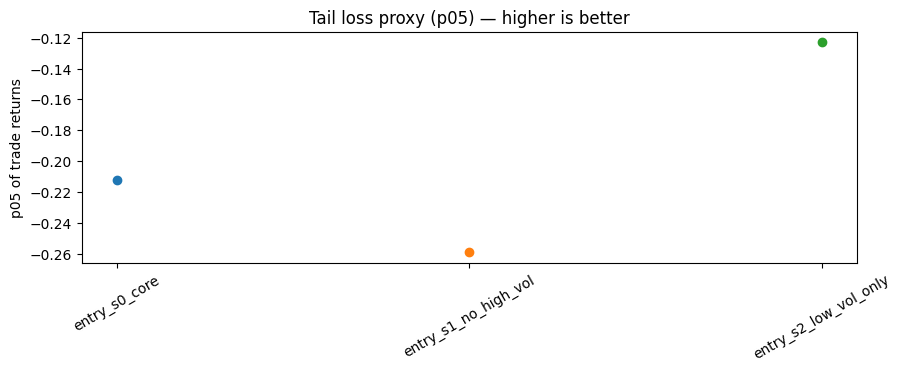

In [11]:
plt.figure(figsize=(10,3))
for v in variants:
    sub = overall[overall["label"]==v]
    plt.scatter([v], sub["p05"])
plt.title("Tail loss proxy (p05) — higher is better")
plt.ylabel("p05 of trade returns")
plt.xticks(rotation=30)
plt.show()


In [12]:
split_date = df["trade_date"].quantile(0.5)
early = df[df["trade_date"] <= split_date].copy()
late  = df[df["trade_date"] >  split_date].copy()

rows = []
for v in variants:
    tr_e = simulate_trades_no_overlap(early, v, HOLD_DAYS)
    tr_l = simulate_trades_no_overlap(late, v, HOLD_DAYS)
    rows.append({**perf_summary(tr_e, f"{v}_early")})
    rows.append({**perf_summary(tr_l, f"{v}_late")})

pd.DataFrame(rows).sort_values("label")


,label,n,avg_ret,med_ret,win_rate,p05,p95
0,entry_s0_core_early,68,-0.006265,-0.000485,0.500000,-0.240227,0.167164
1,entry_s0_core_late,41,0.054274,0.044192,0.609756,-0.117898,0.312403
2,entry_s1_no_high_vol_early,30,-0.059929,-0.103213,0.366667,-0.266333,0.170119
3,entry_s1_no_high_vol_late,25,0.025731,0.008825,0.640000,-0.117184,0.213212
4,entry_s2_low_vol_only_early,6,0.013282,0.031277,0.500000,-0.133651,0.139520
5,entry_s2_low_vol_only_late,11,0.097389,0.064444,0.636364,-0.080075,0.393457
